This script check the effect of a bug in SAPRC11 mechanism file (reactions related to N3) on the model calculation of chamber experiments in RECAP-CA

In [45]:
import os, importlib, sys
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from os import listdir
from os.path import join, isfile

sys.path.append('../../code/src')
#importlib.reload(sys.modules['extract_model_data'])
from extract_model_data import extract_model_outfile, get_model_O3_sensitivity, merge_measure_model_data, plot_timeseries_measure_model, plot_scatter_measure_model_redlands, plot_scatter_measure_model_pasadena, extract_isopleth_output, line_intersection, get_CI_T_distribution

In [2]:
# import measurement data
df_chamber_pasadena = pd.read_csv('../../data/final/O3_sensitivity_pasadena.csv')
df_chamber_redlands = pd.read_csv('../../data/final/O3_sensitivity_redlands.csv')
df_chamber_pasadena['Date'] = pd.to_datetime(df_chamber_pasadena['Date'], format='%m/%d/%Y')
df_chamber_redlands['Date'] = pd.to_datetime(df_chamber_redlands['Date'], format='%m/%d/%Y')

# get MDA8 O3
df_MDA8_pasadena = pd.read_csv('../../data/final/MDA8_O3_pasadena.csv')
df_MDA8_redlands = pd.read_csv('../../data/final/MDA8_O3_redlands.csv')
df_MDA8_pasadena['Date'] = pd.to_datetime(df_MDA8_pasadena['Date'])
df_MDA8_redlands['Date'] = pd.to_datetime(df_MDA8_redlands['Date'])

# get temperature
df_temp_pasadena = pd.read_csv('../../data/final/temp_morning_daily_avg_pasadena.csv')
df_temp_redlands = pd.read_csv('../../data/final/temp_morning_daily_avg_redlands.csv')
df_temp_pasadena['Date'] = pd.to_datetime(df_temp_pasadena['Date'])
df_temp_redlands['Date'] = pd.to_datetime(df_temp_redlands['Date'])

In [8]:
filepath_basecase = '../../data/final/Chamber_model_result_ambienttemp_pasadena_corPTR/pasadena_4km_2021_basecase_corPTR.out'
filepath_NOx_addition = '../../data/final/Chamber_model_result_ambienttemp_pasadena_corPTR/pasadena_4km_2021_NOx-addition_corPTR.out'
df_model_pasadena_old = get_model_O3_sensitivity(filepath_basecase, filepath_NOx_addition)

filepath_basecase = '../../data/final/pasadena_4km_2021_basecase_chambertemp_fixN3bug.out'
filepath_NOx_addition = '../../data/final/pasadena_4km_2021_NOx-addition_chambertemp_fixN3bug.out'
df_model_pasadena = get_model_O3_sensitivity(filepath_basecase, filepath_NOx_addition)

In [38]:
filepath_basecase = '../../data/final/Chamber_model_result_chambertemp/redlands_4km_2021_basecase-cor-v2_chambertemp.out'
filepath_NOx_addition = '../../data/final/Chamber_model_result_chambertemp/redlands_4km_2021_NOx-addition-cor-v2_chambertemp.out'
df_model_redlands_old = get_model_O3_sensitivity(filepath_basecase, filepath_NOx_addition)

filepath_basecase = '../../data/final/redlands_4km_2021_basecase_chambertemp_fixN3bug.out'
filepath_NOx_addition = '../../data/final/redlands_4km_2021_NOx-addition_chambertemp_fixN3bug.out'
df_model_redlands = get_model_O3_sensitivity(filepath_basecase, filepath_NOx_addition)

df_model_redlands.sort_values(by=['Date'], inplace=True)
df_model_redlands_old.sort_values(by=['Date'], inplace=True)

# Compare old vs. updated (mechanism) model results

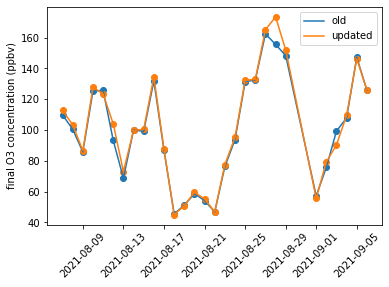

In [32]:
fig, ax=plt.subplots(1,2)
ax.scatter(df_model_pasadena_old['Date'], df_model_pasadena_old['O3_final'])
ax.plot(df_model_pasadena_old['Date'], df_model_pasadena_old['O3_final'], label='old')
ax.scatter(df_model_pasadena['Date'], df_model_pasadena['O3_final'])
ax.plot(df_model_pasadena['Date'], df_model_pasadena['O3_final'], label='updated')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel('final O3 concentration (ppbv)')
plt.show()

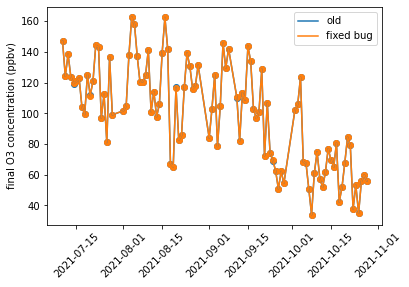

In [41]:
fig, ax=plt.subplots(1,1)
ax.scatter(df_model_redlands_old['Date'], df_model_redlands_old['O3_final'])
ax.plot(df_model_redlands_old['Date'], df_model_redlands_old['O3_final'], label='old')
ax.scatter(df_model_redlands['Date'], df_model_redlands['O3_final'])
ax.plot(df_model_redlands['Date'], df_model_redlands['O3_final'], label='fixed bug')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel('final O3 concentration (ppbv)')
plt.show()

# Plot model vs. measurement plots

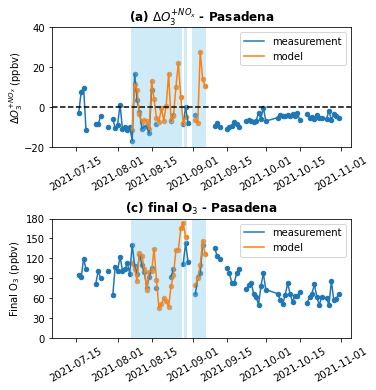

In [14]:
df_measure_model_pasadena = \
    merge_measure_model_data(df_chamber_pasadena, df_temp_pasadena,
                             df_MDA8_pasadena, df_model_pasadena, 'pasadena')
fig = plot_timeseries_measure_model(df_measure_model_pasadena, 'Pasadena')

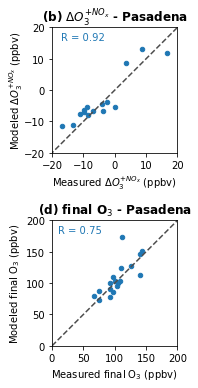

In [15]:
fig = plot_scatter_measure_model_pasadena(df_measure_model_pasadena, 'Pasadena')

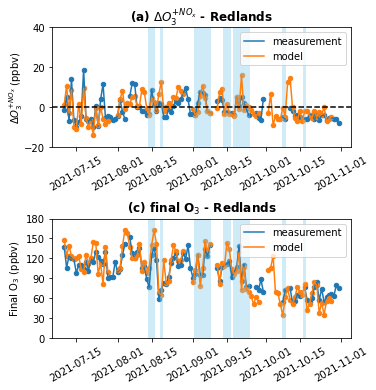

In [16]:
df_measure_model_redlands = \
    merge_measure_model_data(df_chamber_redlands, df_temp_redlands,
                             df_MDA8_redlands, df_model_redlands, 'redlands')
fig = plot_timeseries_measure_model(df_measure_model_redlands, 'Redlands')

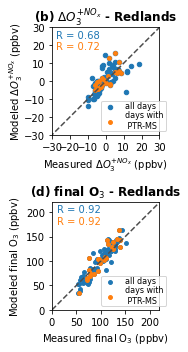

In [17]:
fig = plot_scatter_measure_model_redlands(df_measure_model_redlands)

# O3 isopleth
## Pasadena

In [24]:
folder_path = '../../data/final/Chamber_model_results_ambienttemp_pasadena_fixN3bug/'
df_init_pasadena, df_isopleth_pasadena = extract_isopleth_output(folder_path, 'Pasadena')

In [25]:
df_ambient_pasadena = pd.read_csv('../../data/final/daily_avg_initial_conc_pasadena.csv')
df_ambient_pasadena['Date'] = pd.to_datetime(df_ambient_pasadena['Date'])
df_measure_model = df_measure_model_pasadena.merge(df_ambient_pasadena[['Date','NOx','NOy']], on='Date', how='left')

# add ambient NOx data to the isopleth to draw the CI of NOx
df_init = df_measure_model.merge(df_init_pasadena, on='Date', how='left')
df_init.columns = ['Date','bag2_3hr','b1_b2_3hr','b3_b2_3hr','Temp','MDA8','Month', 'Week', 'O3_final','delta_O3','NOx_amb','NOy_amb','NOx','VOC']
df_init.loc[df_init['NOx'].notna(), 'NOx_amb'] = df_init.loc[df_init['NOx'].notna(), 'NOx']

In [26]:
# Prepare input data
df_iso = df_isopleth_pasadena
#df_init = df_init_pasadena.merge(df_measure_model_pasadena, on='Date', how='left')

# seperate date by temperature
date_T1 = df_init[df_init['MDA8']<50]['Date']
date_T2 = df_init[(df_init['MDA8']>50)&(df_init['MDA8']<70)]['Date']
date_T3 = df_init[(df_init['MDA8']>70)&(df_init['MDA8']<90)]['Date']
date_T4 = df_init[df_init['MDA8']>=90]['Date']
date_T1 = pd.to_datetime(date_T1)
date_T2 = pd.to_datetime(date_T2)
date_T3 = pd.to_datetime(date_T3)
date_T4 = pd.to_datetime(date_T4)
date_list = [date_T1, date_T2, date_T3, date_T4]

c:\Users\Shenglun\OneDrive - University of California, Davis\Documents\LA_2021_summer\Repository\LA_2021_summer\code\script\../../code/src\extract_model_data.py:440: RuntimeWarning: invalid value encountered in double_scalars
  y_int = (b2*(a1/a2)-b1)/(a1/a2-1)
C:\Users\Shenglun\AppData\Local\Temp/ipykernel_18088/1176397993.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Shenglun\AppData\Local\Temp/ipykernel_18088/1176397993.py:135: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


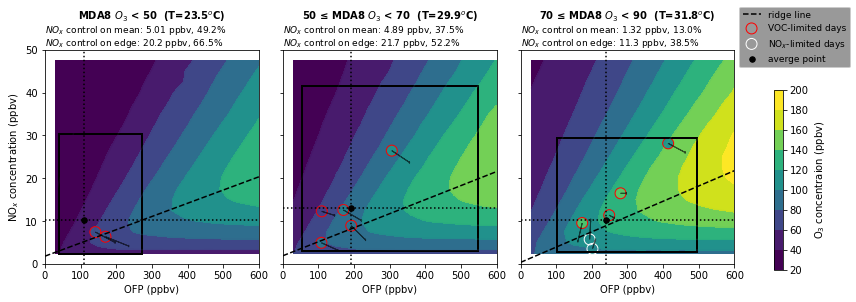

In [28]:
from matplotlib.patches import Rectangle

# Make plot
fig,ax=plt.subplots(1,3,figsize=(12,5),
                     sharey=True)

for i in range(3):
    
    # plot contour line
    df_contour_temp = df_iso[pd.to_datetime(df_iso['Date']).isin(date_list[i])].\
                          groupby(['NOx','VOC']).agg({'O3':'mean'}).reset_index()
    
    #xg = np.arange(25,525,25)
    #yg = np.arange(1.5,31.5,1.5)
    xg=np.arange(30,601,30)
    yg=np.arange(2.5,50,2.5)
    df_contour_temp = df_contour_temp[(df_contour_temp['NOx'].isin(yg))&
                                      (df_contour_temp['VOC'].isin(xg))]
    vg = df_contour_temp.pivot(index='NOx', columns='VOC', values='O3')
    vg = vg.to_numpy()
    cax1 = ax[i].contour(xg, yg, vg, cmap='viridis', vmin=40, vmax=180, alpha=0.2)  # contour line
    cax2 = ax[i].contourf(xg, yg, vg, cmap='viridis', vmin=40, vmax=180)  # contour area
    
    # plot ridge line
    x_int=np.zeros(7)
    y_int=np.zeros(7)
    for j in np.arange(4,7,1):
        polys0 = cax1.allsegs[j]
        x00, y00 = polys0[0].T
        x_int[j-1],y_int[j-1] = line_intersection(x00[18-1*j],y00[18-1*j],
                                                  x00[16-1*j],y00[16-1*j],
                                                  x00[2*j-16],y00[2*j-16],
                                                  x00[2*j-18],y00[2*j-18])
    x_int=x_int[1:7]
    y_int=y_int[1:7]
    mask = ~np.isnan(x_int) & ~np.isnan(y_int)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_int[mask],
                                                                   y_int[mask])
    if i==0 or i==1:
        intercept=intercept+1.8
    else:
        intercept=intercept+0.4
    slope = slope*0.9

    x_ridge = np.arange(0,601,100)
    line_ridge=slope*x_ridge+intercept
    ax[i].plot(x_ridge, line_ridge, c='k', linestyle='dashed', label='ridge line')
        #label='y={:.2f}x+{:.2f} \n$R^2$ ={:.4f}'.format(slope, intercept, r_value))

    # prepare measurement data to plot dots
    df_iso_filter = df_init[(pd.to_datetime(df_init['Date']).isin(date_list[i]))]
    df_VOClimited = df_iso_filter[df_iso_filter['b1_b2_3hr']<0].reset_index()
    df_NOxlimited = df_iso_filter[df_iso_filter['b1_b2_3hr']>0].reset_index()

    # add measured dots in VOC limited
    NOx = df_VOClimited['NOx']
    VOC = df_VOClimited['VOC']
    O3 = df_VOClimited['bag2_3hr']
    b1_b2_3hr = df_VOClimited['b1_b2_3hr']
    b3_b2_3hr = df_VOClimited['b3_b2_3hr']
    cax3 = ax[i].scatter(VOC, NOx, c=O3, cmap='viridis',s=100 ,vmin=40, vmax=180)
    ax[i].scatter(VOC, NOx, s=120, facecolors='none', edgecolors='r', label='VOC-limited days')
    for j in range(len(NOx)):
        ax[i].arrow(x=VOC[j],y=NOx[j],  
                    dx=b3_b2_3hr[j]*500/30/4, dy=b1_b2_3hr[j]/4*(1),
                    head_width=0.5, color='k', alpha=0.6)
        
    # add measured dots in VOC limited
    NOx = df_NOxlimited['NOx']
    VOC = df_NOxlimited['VOC']
    O3 = df_NOxlimited['bag2_3hr']
    b1_b2_3hr = df_NOxlimited['b1_b2_3hr']
    b3_b2_3hr = df_NOxlimited['b3_b2_3hr']
    cax3 = ax[i].scatter(VOC, NOx, c=O3, cmap='viridis',s=100 ,vmin=40, vmax=180)
    ax[i].scatter(VOC, NOx, s=120, facecolors='none', edgecolors='white', label='NO$_x$-limited days')
    for j in range(len(NOx)):
        ax[i].arrow(x=VOC[j],y=NOx[j],  
                    dx=b3_b2_3hr[j]*500/30/4, dy=b1_b2_3hr[j]/4*(1),
                    head_width=0.5, color='k', alpha=0.6)
    
    # add averaged of all dots for each panel
    VOC = df_iso_filter['VOC']
    NOx = df_iso_filter['NOx_amb']
    #ax[i].scatter(VOC, NOx, c='k', s=10 ,label='all points')
    VOC_avg = np.mean(VOC)
    NOx_avg = np.mean(NOx)
    ax[i].scatter(VOC_avg, NOx_avg, c='k', s=30 ,label='averge point')    
    ax[i].axhline(y=NOx_avg, color='k', linestyle=':')
    ax[i].axvline(x=VOC_avg, color='k', linestyle=':')

    # calculate vertical distance between averaged dot to ridge line
    NOx_control_avg = NOx_avg - slope*VOC_avg - intercept
    NOx_control_percentage_avg = NOx_control_avg/NOx_avg*100

    # plot box of CI (log normal distribution)    
    VOC = df_iso_filter.loc[df_iso_filter['VOC'].notna(),'VOC'].tolist()
    NOx = df_iso_filter.loc[df_iso_filter['NOx_amb'].notna(),'NOx_amb'].tolist()    
    log_CI_VOC = get_CI_T_distribution(np.log10(VOC))
    log_CI_NOx = get_CI_T_distribution(np.log10(NOx))
    CI_VOC = [10**x for x in log_CI_VOC]
    CI_NOx = [10**x for x in log_CI_NOx]
    if i==2:
        CI_NOx[1] = CI_NOx[1]+1
    ax[i].add_patch(Rectangle((CI_VOC[0],CI_NOx[0]), CI_VOC[1]-CI_VOC[0], CI_NOx[1]-CI_NOx[0], linewidth=2, edgecolor='k', facecolor='none'))

    # calculate distance of right-edge box to ridge line
    NOx_control_edge = CI_NOx[1] - slope*CI_VOC[1] - intercept
    NOx_control_percentage_edge = round(NOx_control_edge/CI_NOx[1]*100, 1)

    ## add title
    # calculate average temperature
    temp_avg = df_iso_filter[~(df_iso_filter['b1_b2_3hr'].isna())]['Temp'].mean()
    temp_avg_string = f" (T={round(temp_avg,1)}$^o$C)"

    # appearance
    ax[i].set_ylim(0,50)
    ax[i].set_xlim(0,600)
    ax[i].set_box_aspect(1/1)
    ax[i].set_xlabel('OFP (ppbv)')
    title = ['MDA8 $O_3$ < 50','50 ≤ MDA8 $O_3$ < 70',
             '70 ≤ MDA8 $O_3$ < 90', 'MDA8 $O_3$ ≥ 90']
    ax[i].set_title(title[i] + ' ' + temp_avg_string, pad=30, fontsize=10, fontweight='bold')   

    ax[i].annotate(f"$NO_x$ control on mean: {round(NOx_control_avg,2)} ppbv, {round(NOx_control_percentage_avg,1)}%", xy=(0.0, 1.08), xycoords='axes fraction', color='k', size=9) 
    ax[i].annotate(f"$NO_x$ control on edge: {round(NOx_control_edge,1)} ppbv, {round(NOx_control_percentage_edge,1)}%", xy=(0.0, 1.02), xycoords='axes fraction', color='k', size=9)   
    
# add one color bar
ax[0].set_ylabel('NO$_x$ concentration (ppbv)')
ax[2].legend(loc='center left', bbox_to_anchor=(1.0, 1.06), facecolor="gray",fontsize=9)
cbar_ax = fig.add_axes([0.9, 0.18, 0.01, 0.5])
cbar = plt.colorbar(cax2, cax=cbar_ax)
cbar.set_label('O$_3$ concentraion (ppbv)')

plt.tight_layout()
fig.show()

#fig.savefig('../../result/isopleth_ambienttemp_pasadena_lognormal_2std_expand_range_allNOxVOC.png', dpi=1200, bbox_inches='tight', facecolor='white')

## Redlands

In [48]:
folder_path = '../../data/final/Chamber_model_results_ambienttemp_redlands_fixN3bug/'
df_init_redlands, df_isopleth_redlands = extract_isopleth_output(folder_path, 'Redlands')

# Prepare input data
df_iso = df_isopleth_redlands
df_init = df_init_redlands.merge(df_measure_model_redlands, on='Date', how='left')

# seperate date by temperature
date_T1 = df_init[df_init['MDA8']<50]['Date']
date_T2 = df_init[(df_init['MDA8']>50)&(df_init['MDA8']<70)]['Date']
date_T3 = df_init[(df_init['MDA8']>70)&(df_init['MDA8']<90)]['Date']
date_T4 = df_init[df_init['MDA8']>=90]['Date']
date_T1 = pd.to_datetime(date_T1)
date_T2 = pd.to_datetime(date_T2)
date_T3 = pd.to_datetime(date_T3)
date_T4 = pd.to_datetime(date_T4)
date_list = [date_T1, date_T2, date_T3, date_T4]

df_init.loc[df_init['NOx']<1, 'NOx'] = np.nan

C:\Users\Shenglun\AppData\Local\Temp/ipykernel_18088/2860813687.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\Shenglun\AppData\Local\Temp/ipykernel_18088/2860813687.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


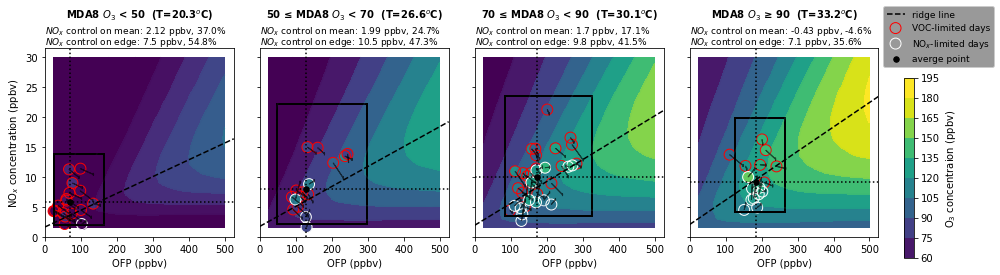

In [50]:
from matplotlib.patches import Rectangle

# Make plot
fig,ax=plt.subplots(1,4,figsize=(14,5),
                    sharey=True)

for i in range(4):
    
    # plot contour line
    df_contour_temp = df_iso[pd.to_datetime(df_iso['Date']).isin(date_list[i])].\
                          groupby(['NOx','VOC']).agg({'O3':'mean'}).reset_index()
    
    xg = np.arange(25,525,25)
    yg = np.arange(1.5,31.5,1.5)
    
    vg = df_contour_temp.pivot(index='NOx', columns='VOC', values='O3')
    vg = vg.to_numpy()
    cax1 = ax[i].contour(xg, yg, vg, cmap='viridis', vmin=60, vmax=180, alpha=0.2)  # contour line
    cax2 = ax[i].contourf(xg, yg, vg, cmap='viridis', vmin=60, vmax=180)  # contour area
    
    # plot ridge line
    x_int=np.zeros(7)
    y_int=np.zeros(7)
    for j in np.arange(3,6,1):
        polys0 = cax1.allsegs[j]
        x00, y00 = polys0[0].T
        x_int[j-1],y_int[j-1] = line_intersection(x00[20-2*j],y00[20-2*j],
                                                  x00[17-2*j],y00[17-2*j],
                                                  x00[3*j-16],y00[3*j-16],
                                                  x00[3*j-18],y00[3*j-18])
                          
    x_int=x_int[1:5]
    y_int=y_int[1:5]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_int,y_int)
    intercept=intercept+1.7
    slope = slope*0.95
    x_ridge = np.arange(0,550,25)
    line_ridge=slope*x_ridge+intercept
    ax[i].plot(x_ridge, line_ridge, c='k', linestyle='dashed', label='ridge line')
        #label='y={:.2f}x+{:.2f} \n$R^2$ ={:.4f}'.format(slope, intercept, r_value))

    # prepare measurement data to plot dots
    df_iso_filter = df_init[(pd.to_datetime(df_init['Date']).isin(date_list[i]))]
    df_VOClimited = df_iso_filter[df_iso_filter['b1_b2_3hr']<0].reset_index()
    df_NOxlimited = df_iso_filter[df_iso_filter['b1_b2_3hr']>0].reset_index()
    
    # add measured dots in VOC limited
    NOx = df_VOClimited['NOx'].tolist()
    VOC = df_VOClimited['VOC'].tolist()
    O3 = df_VOClimited['bag2_3hr']
    b1_b2_3hr = df_VOClimited['b1_b2_3hr']
    b3_b2_3hr = df_VOClimited['b3_b2_3hr']
    cax3 = ax[i].scatter(VOC, NOx, c=O3, cmap='viridis',s=100 ,vmin=60, vmax=180)
    ax[i].scatter(VOC, NOx, s=120, facecolors='none', edgecolors='r', label='VOC-limited days')
    for j in range(len(NOx)):
        ax[i].arrow(x=VOC[j],y=NOx[j],  
                    dx=b3_b2_3hr[j]*500/30/4, dy=b1_b2_3hr[j]/4*(1),
                    head_width=0.5, color='k', alpha=0.6)
        
    # add measured dots in VOC limited
    NOx = df_NOxlimited['NOx']
    VOC = df_NOxlimited['VOC']
    O3 = df_NOxlimited['bag2_3hr']
    b1_b2_3hr = df_NOxlimited['b1_b2_3hr']
    b3_b2_3hr = df_NOxlimited['b3_b2_3hr']
    cax3 = ax[i].scatter(VOC, NOx, c=O3, cmap='viridis',s=100 ,vmin=60, vmax=180)
    ax[i].scatter(VOC, NOx, s=120, facecolors='none', edgecolors='white', label='NO$_x$-limited days')
    for j in range(len(NOx)):
        ax[i].arrow(x=VOC[j],y=NOx[j],  
                    dx=b3_b2_3hr[j]*500/30/4, dy=b1_b2_3hr[j]/4*(1),
                    head_width=0.5, color='k', alpha=0.6)
    
    # add averaged of all dots for each panel
    VOC = df_iso_filter['VOC']
    NOx = df_iso_filter['NOx']
    VOC_avg = VOC.mean()
    NOx_avg = NOx.mean()
    if i ==3:
        NOx_avg = NOx_avg-0.5
    ax[i].scatter(VOC_avg, NOx_avg, c='k', s=30 ,label='averge point')    
    ax[i].axhline(y=NOx_avg, color='k', linestyle=':')
    ax[i].axvline(x=VOC_avg, color='k', linestyle=':')

    # calculate vertical distance between averaged dot to ridge line
    NOx_control_avg = NOx_avg - slope*VOC_avg - intercept
    NOx_control_percentage_avg = NOx_control_avg/NOx_avg*100

    # plot box of CI (log normal distribution)    
    VOC = df_iso_filter['VOC'].tolist()
    NOx = df_iso_filter['NOx'].tolist()       
    log_CI_VOC = get_CI_T_distribution(np.log10(VOC))
    log_CI_NOx = get_CI_T_distribution(np.log10(NOx))
    CI_VOC = [10**x for x in log_CI_VOC]
    CI_NOx = [10**x for x in log_CI_NOx]
    ax[i].add_patch(Rectangle((CI_VOC[0],CI_NOx[0]), CI_VOC[1]-CI_VOC[0], CI_NOx[1]-CI_NOx[0], linewidth=2, edgecolor='k', facecolor='none'))

    # calculate distance of right-edge box to ridge line
    NOx_control_edge = CI_NOx[1] - slope*CI_VOC[1] - intercept
    NOx_control_percentage_edge = round(NOx_control_edge/CI_NOx[1]*100, 1)

    # calculate average temperature
    temp_avg = df_iso_filter[~(df_iso_filter['b1_b2_3hr'].isna())]['Temp'].mean()
    temp_avg_string = f" (T={round(temp_avg,1)}$^o$C)"

    # appearance
    ax[i].set_ylim(0,31.5)
    ax[i].set_xlim(0,525)
    ax[i].set_box_aspect(1/1)
    ax[i].set_xlabel('OFP (ppbv)')
    title = ['MDA8 $O_3$ < 50','50 ≤ MDA8 $O_3$ < 70',
             '70 ≤ MDA8 $O_3$ < 90', 'MDA8 $O_3$ ≥ 90']
    ax[i].set_title(title[i] + ' ' + temp_avg_string, pad=30, fontsize=10, fontweight='bold')   

    ax[i].annotate(f"$NO_x$ control on mean: {round(NOx_control_avg,2)} ppbv, {round(NOx_control_percentage_avg,1)}%", xy=(0.0, 1.08), xycoords='axes fraction', color='k', size=9) 
    ax[i].annotate(f"$NO_x$ control on edge: {round(NOx_control_edge,1)} ppbv, {round(NOx_control_percentage_edge,1)}%", xy=(0.0, 1.02), xycoords='axes fraction', color='k', size=9)

# add one color bar
ax[0].set_ylabel('NO$_x$ concentration (ppbv)')
ax[3].legend(loc='center left', bbox_to_anchor=(1.0, 1.06), facecolor="gray",fontsize=9)
cbar_ax = fig.add_axes([0.9, 0.18, 0.01, 0.5])
cbar = plt.colorbar(cax2, cax=cbar_ax)
cbar.set_label('O$_3$ concentraion (ppbv)')

fig.tight_layout()
fig.show()

#fig.savefig('../../result/isopleth_ambienttemp_redlands_lognormal_2std.png', dpi=1200, bbox_inches='tight', facecolor='white')